In [25]:
_author_ = "Peimeng Sui"
import selenium
import time,re,json,numpy as np
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from selenium import webdriver
from bs4 import BeautifulSoup
import urllib
import pdb
import foursquare
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import glob
%matplotlib
from textblob import TextBlob
import math

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import string
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline
import re
import os

Using matplotlib backend: Qt4Agg


In [26]:
path ='/home/peimengsui/Documents/SpaceJam/craigslist/craigslist_sample' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_)
    head, tail = os.path.split(file_)
    l = re.split('[\_\.]', tail)
    df['loc'] = l[0]
    df['cat'] = l[1]
    list_.append(df)
frame = pd.concat(list_)

In [27]:
word_data = frame.dropna(subset=["title"])

In [28]:
# Remove special characters
rem = string.digits + '/\-+.'
rem_chars = lambda a: ''.join([i for i in a if i not in rem])
word_data['title'] = word_data['title'].apply(rem_chars)

/home/peimengsui/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
# loc_words = {'eby': ['antioch', 'berkeley', 'dublin', 'fremont', 'rockridge',
#                      'livermore', 'mercer', 'ramon'],
#              'nby': ['sausalito', 'marin', 'larkspur', 'novato', 'petaluma', 'bennett', 
#                      'tiburon', 'sonoma', 'anselmo', 'healdsburg', 'rafael'],
#              'sby': ['campbell', 'clara', 'cupertino', 'jose'],
#              'scz': ['aptos', 'capitola', 'cruz', 'felton', 'scotts',
#                      'seabright', 'soquel', 'westside', 'ucsc'],
#              'sfc': ['miraloma', 'soma', 'usf', 'ashbury', 'marina',
#                      'mission', 'noe']}

# # We can append these to sklearn's collection of english "stop" words
# rand_words = ['th', 'xs', 'x', 'bd', 'ok', 'bdr']
# stop_words = [i for j in loc_words.values() for i in j] + rand_words
# stop_words = ENGLISH_STOP_WORDS.union(stop_words)
stop_words = ENGLISH_STOP_WORDS

In [30]:
word_data['loc'].value_counts()

nyc    9598
sf     8763
Name: loc, dtype: int64

In [31]:
word_data['cat'].value_counts()

for          4800
job          4800
housing      4798
community    3963
Name: cat, dtype: int64

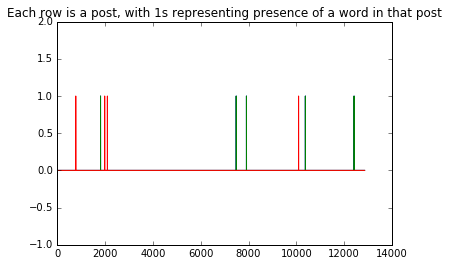

In [43]:
vec = CountVectorizer(max_df=.6, stop_words=stop_words)
vec_tar = LabelEncoder()

counts = vec.fit_transform(word_data['title'])
targets = vec_tar.fit_transform(word_data['cat'])
plt.plot(counts[:3].toarray().T)
plt.ylim([-1, 2])
plt.title('Each row is a post, with 1s representing presence of a word in that post')

In [46]:
top_words = {}
for itrg in np.unique(targets):
    loc = vec_tar.classes_[itrg]
    # Pull only the data points assigned to the current loction
    icounts = counts[targets == itrg, :].sum(0).squeeze()
    
    # Which counts had at least five occurrences
    msk_top_words = icounts > 100
    
    # The inverse transform turns the vectors back into actual words
    top_words[loc] = vec.inverse_transform(msk_top_words)[0]

In [47]:
top_words

{'community': array(['available', 'care', 'child', 'game', 'home', 'looking', 'midtown',
        'music', 'nanny', 'needed', 'nyc', 'poker', 'research', 'studio',
        'study'], 
       dtype='<U65'),
 'for': array(['gb', 'li', 'new', 'rims', 'sale', 'size', 'table', 'vintage'], 
       dtype='<U65'),
 'housing': array(['amazing', 'apartment', 'apt', 'available', 'ave', 'bath',
        'beautiful', 'bed', 'bedroom', 'br', 'brand', 'building', 'condo',
        'district', 'family', 'fee', 'floor', 'free', 'furnished', 'great',
        'hill', 'home', 'house', 'huge', 'large', 'location', 'loft',
        'luxury', 'medical', 'month', 'new', 'office', 'parking', 'prime',
        'private', 'remodeled', 'renovated', 'rent', 'retail', 'room',
        'rooms', 'sf', 'space', 'spacious', 'st', 'street', 'studio',
        'sunny', 'th', 'views'], 
       dtype='<U65'),
 'job': array(['amazon', 'assistant', 'associate', 'cooks', 'delivery', 'driver',
        'drivers', 'earn', 'experienced',

In [48]:
unique_words = {}
for loc, words in top_words.items():
    others = top_words.copy()
    others.pop(loc)
    unique_words[loc] = [wrd for wrd in top_words[loc]
                         if wrd not in np.hstack(others.values())]
for loc, words in unique_words.items():
    print('{0}: {1}\n\n---\n'.format(loc, words))

for: ['gb', 'li', 'rims', 'sale', 'size', 'table', 'vintage']

---

housing: ['amazing', 'apartment', 'apt', 'ave', 'bath', 'beautiful', 'bed', 'bedroom', 'br', 'brand', 'building', 'condo', 'district', 'family', 'fee', 'floor', 'free', 'furnished', 'great', 'hill', 'house', 'huge', 'large', 'location', 'loft', 'luxury', 'medical', 'month', 'parking', 'prime', 'private', 'remodeled', 'renovated', 'rent', 'retail', 'room', 'rooms', 'sf', 'space', 'spacious', 'st', 'street', 'sunny', 'th', 'views']

---

community: ['care', 'child', 'game', 'looking', 'midtown', 'music', 'nanny', 'nyc', 'poker', 'research', 'study']

---

job: ['amazon', 'assistant', 'associate', 'cooks', 'delivery', 'driver', 'drivers', 'earn', 'experienced', 'food', 'hiring', 'hour', 'hr', 'line', 'make', 'manager', 'paid', 'pt', 'restaurant', 'sales', 'san', 'seeking', 'service', 'time', 'wanted', 'week']

---

